In [2]:
import sys

sys.path.append('../xor_neuron')

In [3]:
import pickle
from glob import glob
import os
import yaml
from easydict import EasyDict as edict
import numpy as np
import torch
from scipy.signal import convolve2d, fftconvolve, convolve
from scipy.stats import multivariate_normal
from scipy.optimize import curve_fit
from scipy.spatial.distance import cosine
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.backends.backend_pdf import PdfPages

from model import *
from utils.train_helper import save_outphase, make_mask, load_model

In [61]:
dirs = glob('../exp/MLP_1D_arg/MNIST/*')
dirs.sort(key=os.path.abspath)
dirs

['../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_1_mnist_0954',
 '../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_2_mnist_0954',
 '../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_3_mnist_0954',
 '../exp/MLP_1D_arg/MNIST/ComplexNeuronMLP_4_mnist_0955']

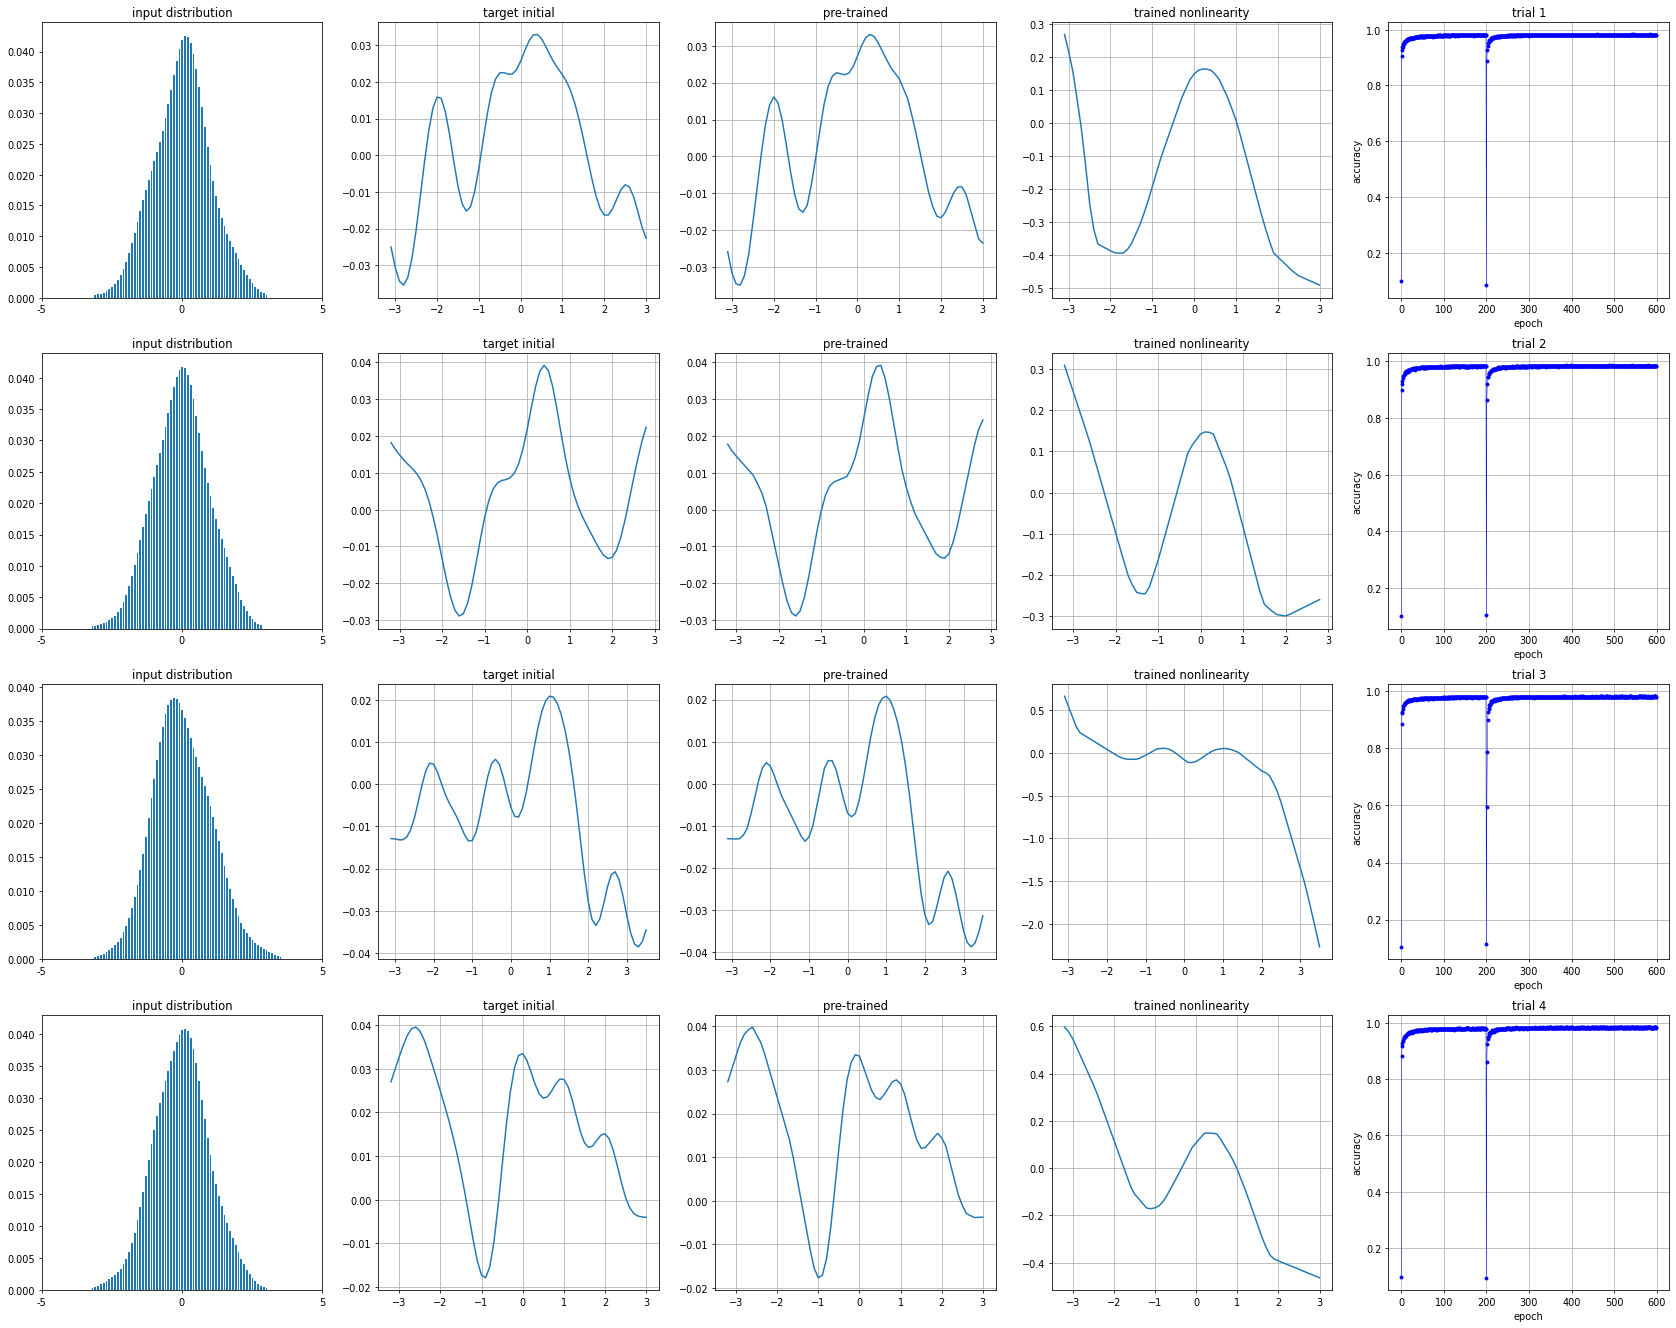

In [62]:
f, axes = plt.subplots(nrows=len(dirs), ncols=5, figsize=(30, 6*len(dirs)), dpi=70)

for ii, dr in enumerate(dirs):
    phase1_file = glob(dr + '/*phase1.p')[0]
    phase2_file = glob(dr + '/*phase2.p')[0]
    phase1_data = pickle.load(open(phase1_file, 'rb'))
    phase2_data = pickle.load(open(phase2_file, 'rb'))

    
    config_file = glob(dr + '/*.yaml')[0]
    config = edict(yaml.load(open(config_file, 'r'), Loader=yaml.FullLoader))
    
    # --- target shape change --- #
    targets = pickle.load(open(dr+'/pretrain_target.p', 'rb'))
    targets = targets.reshape(-1)
    
    target = []
    for i in range(len(targets)):
        if i % 101 == 0:
            target.append(targets[i])

            
    # create models
    model_pretrain = InnerNet(config)
    model_phase1 = InnerNet(config)

    # --- load test model --- #
    load_model(model_pretrain.inner_net, config.model_save + config.pretrain.best_model[0])

    model_snapshot = torch.load(config.model_save + config.train.best_model, map_location=torch.device('cpu'))
    
    for key in list(model_snapshot['model'].keys()):
        model_snapshot['model'][key.replace('0', 'inner_net')] = model_snapshot['model'].pop(key)
        
    model_phase1.load_state_dict(model_snapshot["model"], strict=True)
    
    model_pretrain.eval()
    model_phase1.eval()

    
    # --- Make Mask, PDF, input --- #
    nb = 101
    x = np.linspace(-5, 5, nb)
    mvn = multivariate_normal(mean=0, cov=1/4)
    gaussian_kernel = mvn.pdf(x).reshape(nb)
    gaussian_kernel /= gaussian_kernel.sum()
    
    input2innerAll = glob(dr+'/in2cells.p')[0]
    in2cells = pickle.load(open(input2innerAll, 'rb'))
    in2cells = np.array(in2cells)
    in2cells = np.moveaxis(in2cells, -1, 0)
    xedges = np.arange(-5.05, 5.1, 0.1)
    pdf, _ = np.histogram(in2cells[0], bins=xedges)
    pdf = convolve(pdf, gaussian_kernel, mode='same')
    pdf /= sum(pdf.flatten())

    threshold = 0.0005
    while True:
        idx = np.where(pdf > threshold)
        if sum(pdf[idx]) > 0.9:
            break
        else:
            threshold -= 0.00001
    mask_zeros = np.zeros(101)
    mask_zeros[idx] = 1

    mask_nan = np.empty(101)
    mask_nan[:] = np.nan
    
    mask_nan[idx] = 1
    
    x = x.reshape(nb, 1)
    out_pretrain = model_pretrain.inner_net(torch.Tensor(x))
    out_phase1 = model_phase1.inner_net(torch.Tensor(x))
    
    x_len = [i for i in range(0,600)]   
    # ========== Column 5: Model Accuracy ==============
    axes[ii,4].plot(x_len, np.hstack([phase1_data['val_acc'], phase2_data['val_acc']]), 'b.-', lw=0.5)
    axes[ii,4].set_xlabel('epoch')
    axes[ii,4].set_ylabel('accuracy')
    axes[ii,4].set_title(f'trial {1+ii}')
    axes[ii,4].grid(True)

    
    x = np.linspace(-5, 5, num=101)
    # ========== Column 1: Input distribution ==============
    im = axes[ii,0].bar(x, mask_nan*pdf, edgecolor='white', width = 0.1)
    axes[ii,0].set_title('input distribution')
    axes[ii,0].set_xticks([-5, 0, 5])
    axes[ii,0].set_xticklabels(['-5', '0', '5'])

    
    # ========== Column 2: Target Initial ==============
    tar = mask_zeros * target
    
    min_value = round(np.min(tar),3)
    max_value = round(np.max(tar), 3)

    im = axes[ii,1].plot(x, mask_nan*target)
    axes[ii,1].set_title('target initial')
    axes[ii,1].grid(True)
    
    # ========== Column 3: Pre-trained  ==============
    out_pretrain = out_pretrain.data.numpy().reshape(-1)
    tar = mask_zeros  * out_pretrain
    
    min_value = round(np.min(tar),3)
    max_value = round(np.max(tar), 3)
    
    im = axes[ii,2].plot(x, mask_nan*out_pretrain)
    axes[ii,2].set_title('pre-trained')
    axes[ii,2].grid(True)

    
    # ========== Column 4: Trained nonlinearity ==============
    out_phase1 = out_phase1.data.numpy().reshape(-1)
    tar = mask_zeros * out_phase1
    
    min_value = round(np.min(tar),3)
    max_value = round(np.max(tar), 3)
    im = axes[ii,3].plot(x, mask_nan * out_phase1)
    axes[ii,3].set_title('trained nonlinearity')
    axes[ii,3].grid(True)

f.show()